# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### ResNet & DenseNet (Based on 11/30 Lecture)

> ### **0. Import Libraries and Define Functions**

In [ ]:
pip install d2l

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as data

import warnings
warnings.filterwarnings('ignore')

from torch import nn
from d2l.torch import *
from d2l import torch as d2l
from torch.utils.data import DataLoader
from torch.nn import functional as F

In [3]:
def load_data_cifar10(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.CIFAR10(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

In [4]:
# Residual block of ResNet
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [5]:
# Dense block for DenseNet
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

> ### **1. ResNet Model**

In [30]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [31]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [32]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:    \t', X.shape)

Sequential output shape:    	 torch.Size([1, 64, 56, 56])
Sequential output shape:    	 torch.Size([1, 64, 56, 56])
Sequential output shape:    	 torch.Size([1, 128, 28, 28])
Sequential output shape:    	 torch.Size([1, 256, 14, 14])
Sequential output shape:    	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:    	 torch.Size([1, 512, 1, 1])
Flatten output shape:    	 torch.Size([1, 512])
Linear output shape:    	 torch.Size([1, 10])


**◦ CIFAR10**

loss 0.000, train acc 1.000, test acc 0.767
592.1 examples/sec on cuda:0


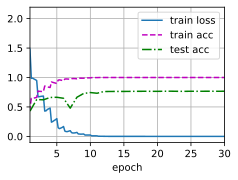

In [33]:
# Takes about 30 min
lr, num_epochs, batch_size = 0.06, 30, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> ### **2. DenseNet Model**

In [18]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # The number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # Transition layer that halves the number of channels is added between dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [19]:
net = nn.Sequential(
      b1, *blks,
      nn.BatchNorm2d(num_channels), nn.ReLU(),
      nn.AdaptiveMaxPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(num_channels, 10))

In [20]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:      \t', X.shape)

Sequential output shape:      	 torch.Size([1, 64, 56, 56])
DenseBlock output shape:      	 torch.Size([1, 192, 56, 56])
Sequential output shape:      	 torch.Size([1, 96, 28, 28])
DenseBlock output shape:      	 torch.Size([1, 224, 28, 28])
Sequential output shape:      	 torch.Size([1, 112, 14, 14])
DenseBlock output shape:      	 torch.Size([1, 240, 14, 14])
Sequential output shape:      	 torch.Size([1, 120, 7, 7])
DenseBlock output shape:      	 torch.Size([1, 248, 7, 7])
BatchNorm2d output shape:      	 torch.Size([1, 248, 7, 7])
ReLU output shape:      	 torch.Size([1, 248, 7, 7])
AdaptiveMaxPool2d output shape:      	 torch.Size([1, 248, 1, 1])
Flatten output shape:      	 torch.Size([1, 248])
Linear output shape:      	 torch.Size([1, 10])


**◦ CIFAR10**

loss 0.001, train acc 1.000, test acc 0.817
749.2 examples/sec on cuda:0


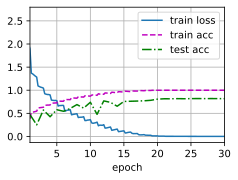

In [21]:
# Takes about 40 min
lr, num_epochs, batch_size = 0.1, 30, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> ### **4. Compare Training Results (CIFAR10)**

- #### **ResNet Model**
  - **Params** : learning rate, num_epochs, batch_size = 0.06, 30, 128
  - **Result** : loss 0.000, train acc 1.000, test acc 0.767
  - **Opinion** : Good model, fast and accurate.

- #### **DenseNet Model**
  - **Params** : learning rate, num_epochs, batch_size = 0.1, 30, 128
  - **Result** : loss 0.001, train acc 1.000, test acc 0.817
  - **Opinion** : Slower than ResNet but more accurate.

- #### **Accuracy**
  - DenseNet > ResNet
  - High accuracy in taining set, low in test set (Overfitting)